https://github.com/NanoComp/meep/blob/master/python/examples/holey-wvg-cavity.ipynb

In [2]:
import math
import meep as mp
from meep import mpb

import numpy as np
import matplotlib.pyplot as plt

In [13]:
resolution = 20   # pixels/um

eps = 13          # dielectric constant of waveguide
w = 1.2           # width of waveguide
r = 0.36          # radius of holes
d = 1.4           # defect spacing (ordinary spacing = 1)
N = 3             # number of holes on either side of defect

sy = 6            # size of cell in y direction (perpendicular to wvg.)
pad = 2           # padding between last hole and PML edge
dpml = 1          # PML thickness

fcen = 0.25   # pulse center frequency
df = 0.2       # pulse frequency width

pml_layers = [mp.PML(1.0)]
sym = [mp.Mirror(mp.Y, phase=-1)]

In [14]:
def sim_cavity(N=3,sy=6):
    sx = 2*(pad+dpml+N)+d-1  # size of cell in x direction
    cell = mp.Vector3(sx,sy,0)
    blk = mp.Block(size=mp.Vector3(mp.inf,w,mp.inf), material=mp.Medium(epsilon=eps))
    geometry = [blk]

    for i in range(N):
            geometry.append(mp.Cylinder(r, center=mp.Vector3(d/2+i)))
            geometry.append(mp.Cylinder(r, center=mp.Vector3(-(d/2+i))))
    
    src = [mp.Source(mp.GaussianSource(fcen, fwidth=df),
                 component=mp.Ey,
                 center=mp.Vector3(-0.5*sx+dpml),
                 size=mp.Vector3(0,w))]
    
    sim = mp.Simulation(cell_size=cell,
                    geometry=geometry,
                    boundary_layers=pml_layers,
                    sources=src,
                    symmetries=sym,
                    resolution=resolution)
    
    freg = mp.FluxRegion(center=mp.Vector3(0.5*sx-dpml-0.5),
                     size=mp.Vector3(0,2*w))
    nfreq = 500
    trans = sim.add_flux(fcen, df, nfreq, freg)
    
    sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ey, mp.Vector3(0.5*sx-dpml-0.5), 1e-3))
    
    freqs = mp.get_flux_freqs(trans)
    psd = mp.get_fluxes(trans)

    return freqs, psd

In [15]:
freqs_wg, psd_wg = sim_cavity(N=0) # simple waveguide
freqs_cav, psd_cav = sim_cavity() # cavity

-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00157595 s
Working in 2D dimensions.
Computational cell is 6.4 x 6 x 0 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
time for set_epsilon = 0.0177131 s
-----------
field decay(t = 50.025000000000006): 0.024304124551377575 / 0.024304124551377575 = 1.0
field decay(t = 100.05000000000001): 0.0002947877364436929 / 0.024304124551377575 = 0.012129123837418126
field decay(t = 150.07500000000002): 8.91466965487548e-14 / 0.024304124551377575 = 3.6679657545493404e-12
run 0 finished at t = 150.07500000000002 (6003 timesteps)
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.000725031 s
Working in 2D dimensions.
Computational cell is 12.4 x 6 x 0 with resolution 20
     block, center

In [16]:
print(freqs_wg)
print(psd_wg) 

[0.15, 0.1504008016032064, 0.1508016032064128, 0.15120240480961925, 0.15160320641282565, 0.15200400801603206, 0.15240480961923847, 0.15280561122244488, 0.15320641282565128, 0.15360721442885772, 0.15400801603206413, 0.15440881763527053, 0.15480961923847694, 0.15521042084168335, 0.15561122244488979, 0.1560120240480962, 0.1564128256513026, 0.156813627254509, 0.15721442885771542, 0.15761523046092185, 0.15801603206412826, 0.15841683366733467, 0.15881763527054107, 0.15921843687374748, 0.1596192384769539, 0.16002004008016033, 0.16042084168336673, 0.16082164328657314, 0.16122244488977955, 0.16162324649298596, 0.1620240480961924, 0.1624248496993988, 0.1628256513026052, 0.16322645290581161, 0.16362725450901802, 0.16402805611222443, 0.16442885771543087, 0.16482965931863727, 0.16523046092184368, 0.1656312625250501, 0.1660320641282565, 0.16643286573146293, 0.16683366733466934, 0.16723446893787575, 0.16763527054108215, 0.16803607214428856, 0.168436873747495, 0.1688376753507014, 0.1692384769539078, 0

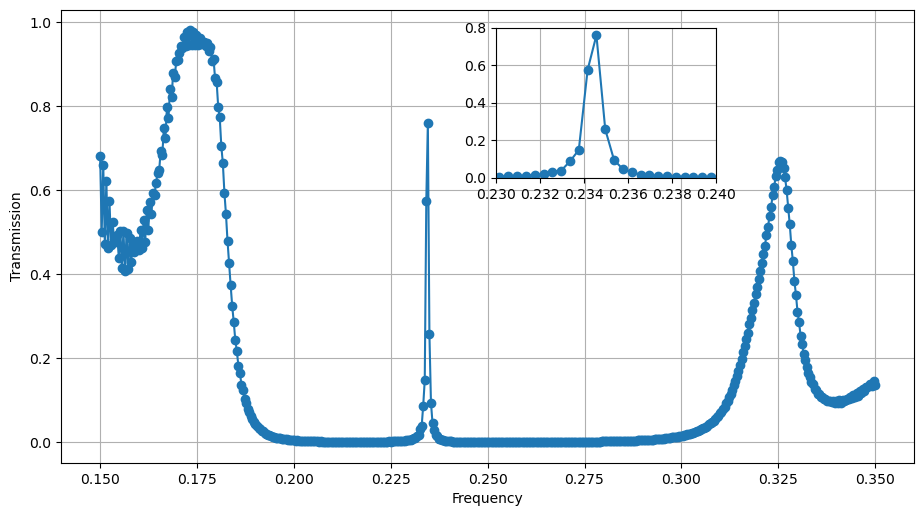

In [17]:

fig = plt.figure(figsize=(11,6),dpi=100)
ax = fig.add_subplot(111)
plt.plot(freqs_cav,np.array(psd_cav)/np.array(psd_wg),'o-')
plt.grid(True)
plt.xlabel('Frequency')
plt.ylabel('Transmission')

ax2 = fig.add_axes([0.52, 0.6, 0.2, 0.25])
plt.plot(freqs_cav,np.array(psd_cav)/np.array(psd_wg),'o-')
plt.xlim(0.23,0.24)
plt.ylim(0,0.8)
plt.grid(True)

## Resonant mode

In [20]:
def sim_cavity(N=3,sy=6,fcen=0.25,df=0.2):
    sx = 2*(pad+dpml+N)+d-1  # size of cell in x direction
    cell = mp.Vector3(sx,sy,0)
    blk = mp.Block(size=mp.Vector3(mp.inf,w,mp.inf), material=mp.Medium(epsilon=eps))
    geometry = [blk]

    for i in range(N):
            geometry.append(mp.Cylinder(r, center=mp.Vector3(d/2+i)))
            geometry.append(mp.Cylinder(r, center=mp.Vector3(-(d/2+i))))
    
    src = [mp.Source(mp.GaussianSource(fcen, fwidth=df), mp.Hz, mp.Vector3(0))]
    
    sym = [mp.Mirror(mp.Y, phase=-1), mp.Mirror(mp.X, phase=-1)]
    
    sim = mp.Simulation(cell_size=cell,
                    geometry=geometry,
                    boundary_layers=pml_layers,
                    sources=src,
                    symmetries=sym,
                    resolution=resolution)
    
    return sim

-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00106907 s
Working in 2D dimensions.
Computational cell is 12.4 x 6 x 0 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     cylinder, center = (0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylin

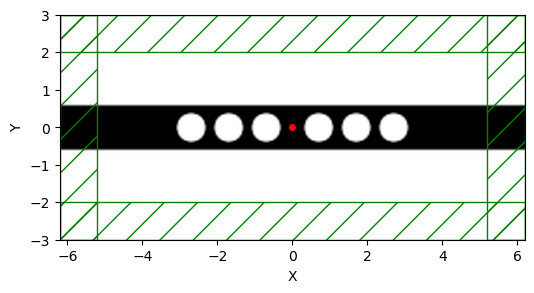

In [21]:
sim = sim_cavity()
f = plt.figure(dpi=100)
sim.plot2D(ax=f.gca())
plt.show()

In [22]:
h = mp.Harminv(mp.Hz, mp.Vector3(), fcen, df)
sim.run(mp.after_sources(h),
        until_after_sources=400)

f = plt.figure(dpi=150)
animate = mp.Animate2D(sim,f=f,fields=mp.Hz,realtime=False,normalize=True)

sim.run(mp.at_every(1/fcen/20, animate), until=1/fcen)
plt.close()

harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.2344541534601369, -0.00031478123675223054, 372.4080823227078, 5.8121430335563815, -3.7631074855608966-4.429450157145187i, 4.306921732234943e-09+0.0i
run 0 finished at t = 450.0 (18000 timesteps)
Normalizing field data...
run 1 finished at t = 454.0 (18160 timesteps)


In [25]:
filename = 'hole-wvg-cavity-res.mp4'
animate.to_mp4(10,filename)
from IPython.display import Video
Video(filename)

Generating MP4...


In [26]:
f = [m.freq for m in h.modes]
Q = [m.Q for m in h.modes]

for fiter, qiter in zip(f, Q):
    print(f'Resonant frequency: {fiter}, Q: {qiter}')

Resonant frequency: 0.2344541534601369, Q: 372.4080823227078
